In [107]:
import numpy as np
import matplotlib.pyplot as plt
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from concurrent.futures import ThreadPoolExecutor, as_completed

network = "OO"
station = "HYSB1"
location = ""
channel = "BHZ"
client = Client("IRIS")

# Define a function to calculate peak ground velocity
def calculate_pgv(stream, inventory):
    try:
        # Detrend and taper the data
        stream.detrend("demean")
        stream.detrend("linear")
        stream.taper(max_percentage=0.05)
        
        # Remove the instrumental response to get velocity
        pre_filt = (0.005, 0.006, 80.0, 100.0)  # Bandpass filter parameters
        stream.remove_response(inventory=inventory, output='VEL', pre_filt=pre_filt, zero_mean=False, taper=False)
        
        # Calculate PGV (maximum absolute amplitude)
        pgv = np.max(np.abs(stream[0].data))
        
        return pgv
    except Exception as e:
        print(f"Failed to process data: {e}")
        return None



In [108]:
# Fetch the inventory once
inventory = client.get_stations(network=network, station=station, location=location,
                                channel=channel, level="response", starttime=UTCDateTime("2014-10-01"),
                                endtime=UTCDateTime("2020-12-31"))

# Define the start and end date for the data request
start_date = UTCDateTime("2014-10-01")
end_date = UTCDateTime("2020-12-31")

# Initialize an empty list to store results
pgv_results = []

def process_day(current_date):
    try:
        # Fetch the data for the current day
        st = client.get_waveforms(network=network, station=station, location=location,
                                  channel=channel, starttime=current_date,
                                  endtime=current_date + 86400)
        # Calculate PGV for the current day
        pgv = calculate_pgv(st, inventory)
        return (current_date.date, pgv)
    except Exception as e:
        print(f"Failed to process data for {current_date.date}: {e}")
        return (current_date.date, None)

# Use ThreadPoolExecutor to parallelize the process
with ThreadPoolExecutor(max_workers=10) as executor:
    futures = []
    current_date = start_date
    while current_date <= end_date:
        futures.append(executor.submit(process_day, current_date))
        current_date += 86400

    for future in as_completed(futures):
        result = future.result()
        if result[1] is not None:
            pgv_results.append(result)
            print(f"PGV for {result[0]}: {result[1]:.4f}")

# Save results to a CSV file
output_file = "pgv_results.csv"
with open(output_file, 'w') as f:
    f.write("Date,PGV\n")
    for date, pgv in pgv_results:
        f.write(f"{date},{pgv:.4f}\n")

print(f"Results saved to {output_file}")


In [109]:
def process_day(current_date):
    try:
        # Fetch the data for the current day
        st = client.get_waveforms(network=network, station=station, location=location,
                                  channel=channel, starttime=current_date,
                                  endtime=current_date + 86400)
        # Calculate PGV for the current day
        pgv = calculate_pgv(st, inventory)
        return (current_date.date, pgv)
    except Exception as e:
        print(f"Failed to process data for {current_date.date}: {e}")
        return (current_date.date, None)



In [110]:
# Use ThreadPoolExecutor to parallelize the process
with ThreadPoolExecutor(max_workers=10) as executor:
    futures = []
    current_date = start_date
    while current_date <= end_date:
        futures.append(executor.submit(process_day, current_date))
        current_date += 86400

    for future in as_completed(futures):
        result = future.result()
        if result[1] is not None:
            pgv_results.append(result)
            print(f"PGV for {result[0]}: {result[1]:.4f}")



 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.


PGV for 2016-07-09: 0.0001
PGV for 2016-07-13: 0.0000
Failed to process data for 2016-07-16: No data available for request.
HTTP Status code: 204
Detailed response of server:


Failed to process data for 2016-07-17: No data available for request.
HTTP Status code: 204
Detailed response of server:


PGV for 2016-07-18: 0.0489
PGV for 2016-07-10: 0.0000
PGV for 2016-07-14: 0.0000
PGV for 2016-07-08: 0.0000
PGV for 2016-07-11: 0.0001
PGV for 2016-07-07: 0.0000
PGV for 2016-07-05: 0.0000
PGV for 2016-07-06: 0.0000
PGV for 2016-07-12: 0.0000
PGV for 2016-07-15: 0.0000
PGV for 2016-07-23: 0.0001
PGV for 2016-07-25: 0.0000
PGV for 2016-07-21: 0.0000
PGV for 2016-07-24: 0.0000
PGV for 2016-07-27: 0.0000
PGV for 2016-07-19: 0.0004
PGV for 2016-07-20: 0.0000
PGV for 2016-07-22: 0.0000
PGV for 2016-07-26: 0.0000
PGV for 2016-07-28: 0.0000
PGV for 2016-07-30: 0.0001
PGV for 2016-07-29: 0.0002
PGV for 2016-07-31: 0.0001
PGV for 2016-08-01: 0.0000
PGV for 2016-08-02: 0.0000
PGV for 2016-08-04: 0.000

In [5]:
# Sort results by date
pgv_results.sort(key=lambda x: x[0])

# Save results to a CSV file
output_file = "pgv_results_newnew.csv"
with open(output_file, 'w') as f:
    f.write("Date,PGV\n")
    for date, pgv in pgv_results:
        f.write(f"{date},{pgv:.4f}\n")

print(f"Results saved to {output_file}")


Results saved to pgv_results_new.csv


In [112]:
pgv_results.sort(key=lambda x: x[0])

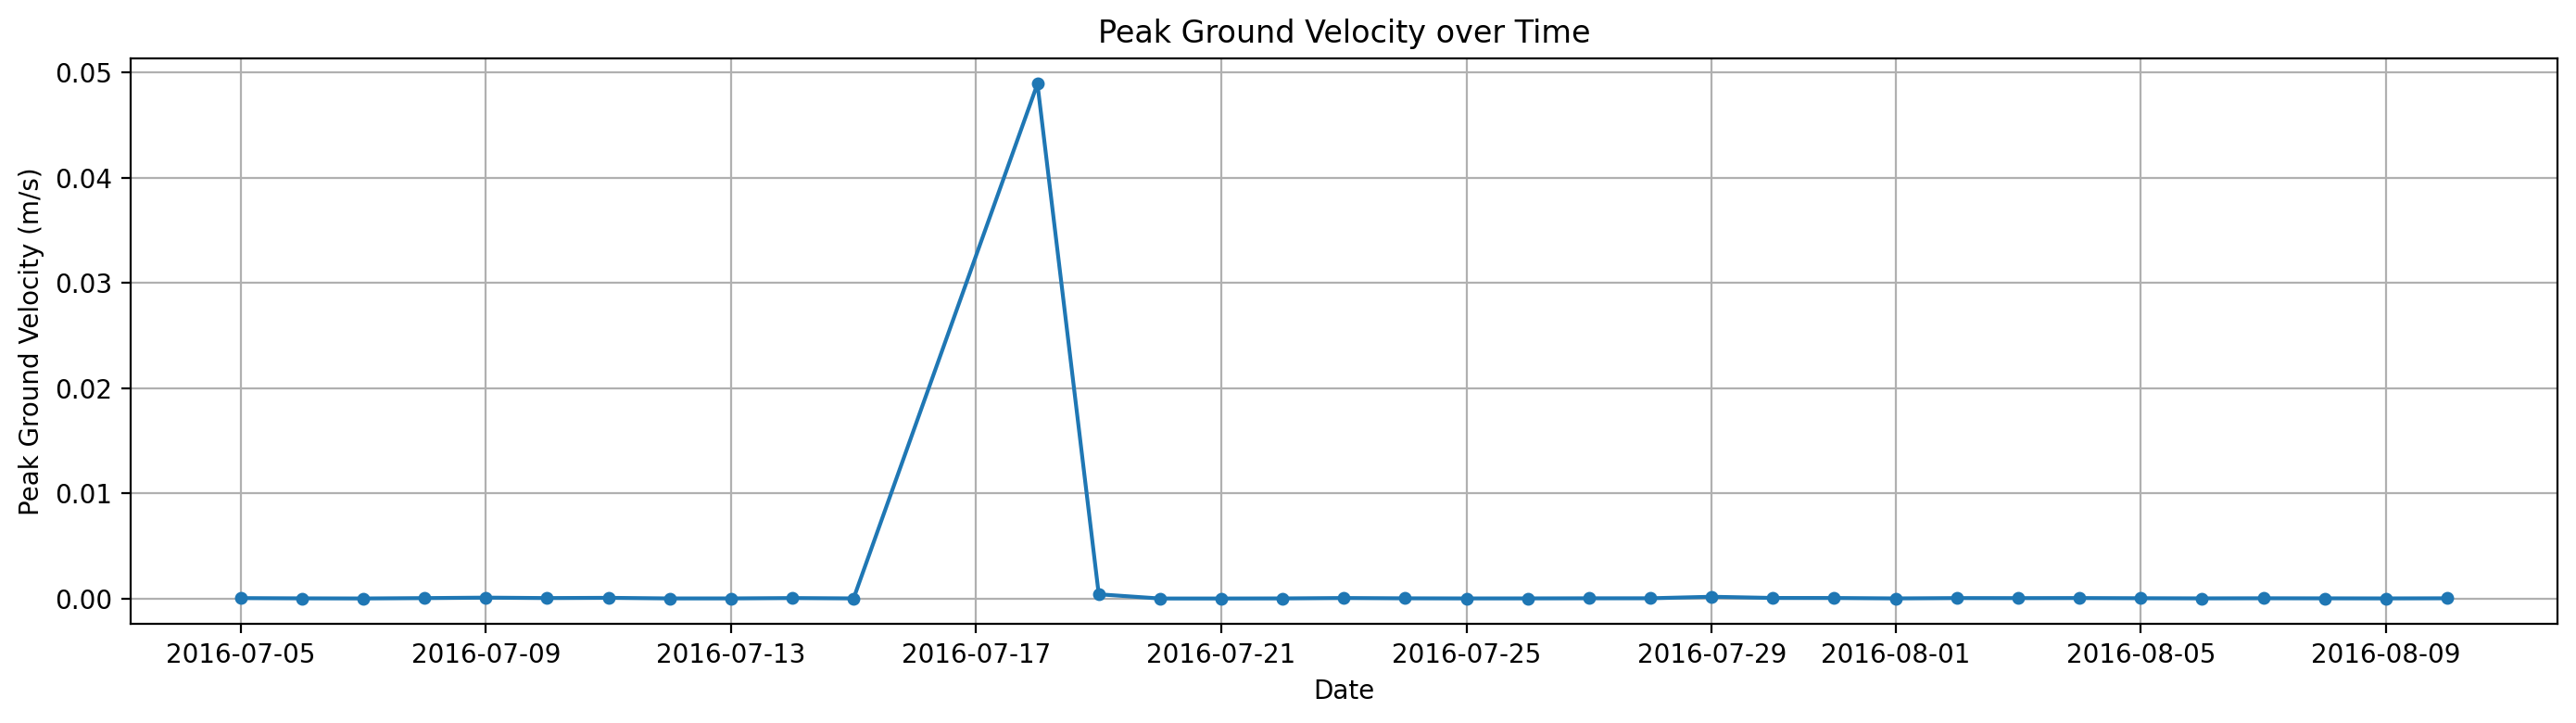

In [113]:
# Plot PGV as a function of time
dates, pgvs = zip(*pgv_results)
plt.figure(figsize=(14, 4),dpi=200)
plt.plot(dates, pgvs, marker='o', linestyle='-', markersize=4)
plt.xlabel('Date')
plt.ylabel('Peak Ground Velocity (m/s)')
plt.title('Peak Ground Velocity over Time')
plt.grid(True)
plt.tight_layout()
plt.savefig('pgv_plot.png')
plt.show()

In [95]:
pgv_results

[]